# Cat and Dog Image Classifier

For this challenge, you will complete the code to classify images of dogs and cats. You will use TensorFlow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time. (Extra credit if you get it to 70% accuracy!)

```cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]```

## Setup

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Download and explore the dataset

In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
BATCH_SIZE = 128
EPOCHS = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

## Load data using Keras utility

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=False,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels=None,
    shuffle=False,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
print(class_names)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 50 files belonging to 1 classes.
['cats', 'dogs']


## Visualize the data

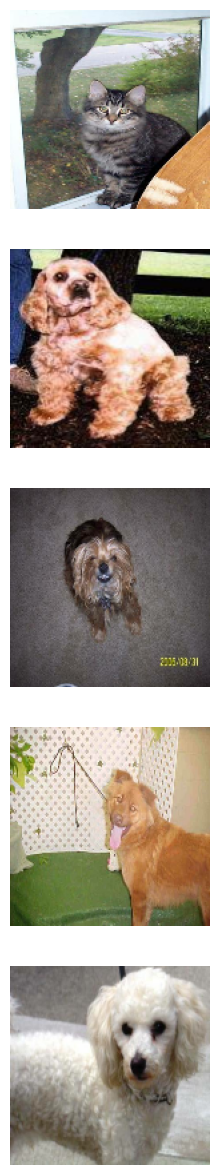

In [4]:
# 4
def plotImages(images_arr, probabilities=False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))
    if probabilities is False:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis("off")
    else:
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis("off")
            if probability > 0.5:
                ax.set_title("%.2f" % (probability * 100) + "% dog")
            else:
                ax.set_title("%.2f" % ((1 - probability) * 100) + "% cat")
    plt.show()

normalization_layer = tf.keras.layers.Rescaling(1./255)
sample_training_images = train_ds.map(lambda x, y: (normalization_layer(x), y))

for image, label in sample_training_images.take(1):
    sample_training_images = image

plotImages(sample_training_images.numpy()[:5])

(128, 150, 150, 3)
(128,)


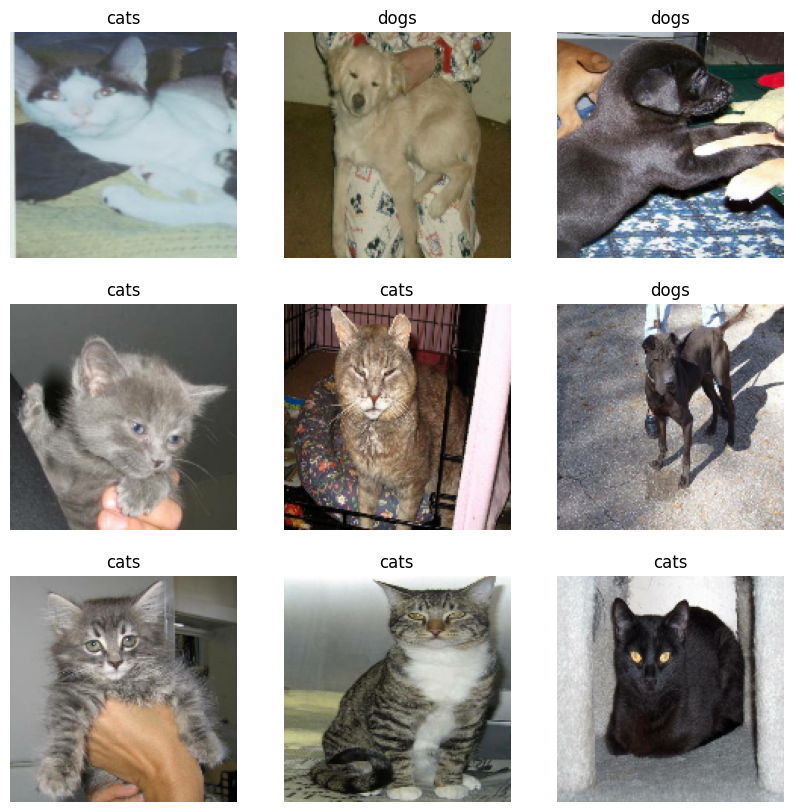

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data augmentation

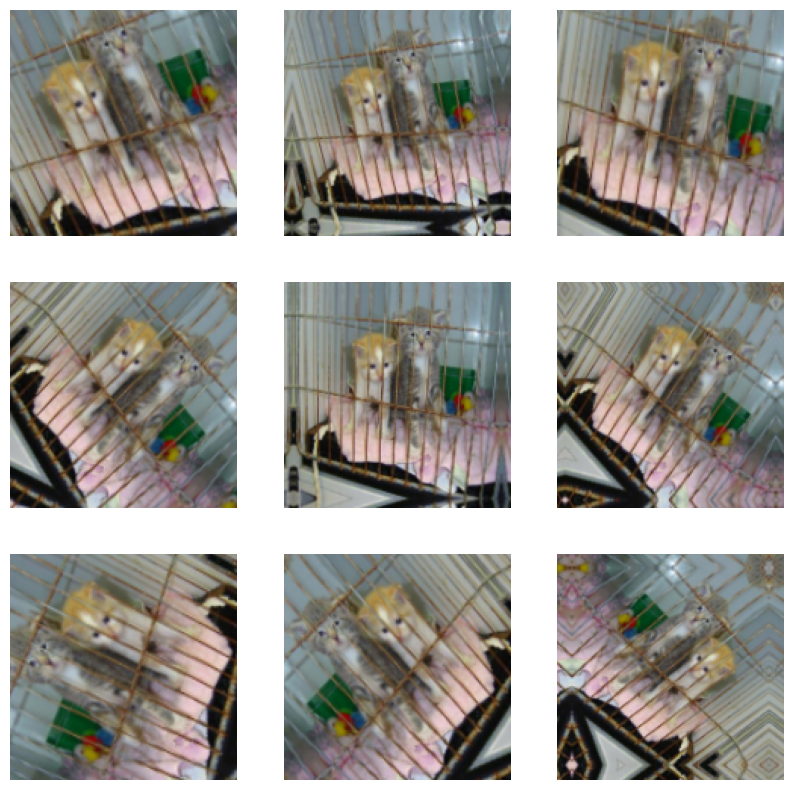

In [6]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

data_augmentation = tf.keras.Sequential(
[
    tf.keras.layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Keras model, compile and train model

In [7]:
model = Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer='adam',
            loss="binary_crossentropy",
            metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                 

In [9]:
# 8
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
16/16 [==============================] - 19s 241ms/step - loss: 0.7373 - accuracy: 0.4935 - val_loss: 0.6781 - val_accuracy: 0.5200
Epoch 2/15
16/16 [==============================] - 1s 86ms/step - loss: 0.6681 - accuracy: 0.5545 - val_loss: 0.6390 - val_accuracy: 0.6330
Epoch 3/15
16/16 [==============================] - 1s 82ms/step - loss: 0.6385 - accuracy: 0.6285 - val_loss: 0.6126 - val_accuracy: 0.6650
Epoch 4/15
16/16 [==============================] - 1s 81ms/step - loss: 0.6152 - accuracy: 0.6650 - val_loss: 0.5886 - val_accuracy: 0.6940
Epoch 5/15
16/16 [==============================] - 1s 81ms/step - loss: 0.6054 - accuracy: 0.6635 - val_loss: 0.5862 - val_accuracy: 0.6950
Epoch 6/15
16/16 [==============================] - 1s 81ms/step - loss: 0.5877 - accuracy: 0.6900 - val_loss: 0.5889 - val_accuracy: 0.6910
Epoch 7/15
16/16 [==============================] - 1s 81ms/step - loss: 0.5809 - accuracy: 0.6940 - val_loss: 0.5677 - val_accuracy: 0.7070
Epoch 8/15


## Visualize training results

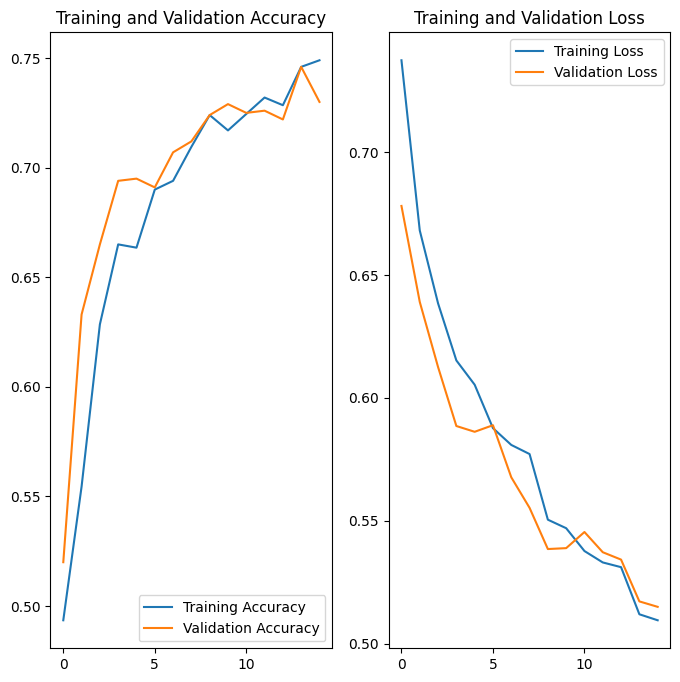

In [10]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Predict on test data, visualize predictions, and test model

In [11]:
probabilities = model.predict(test_ds).flatten()

1/1 [==============================] - 0s 346ms/step


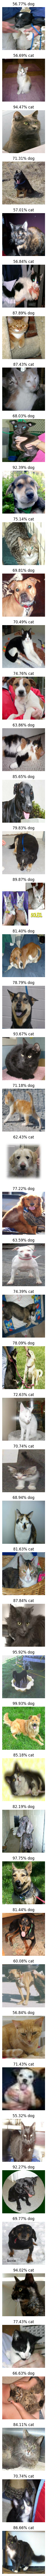

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
sample_testing_images = test_ds.map(lambda x: normalization_layer(x))

for image in sample_testing_images.take(-1):
    sample_testing_images = image

plotImages(sample_testing_images.numpy(), probabilities)

In [13]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
    if round(probability) == answer:
        correct += 1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(
    f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs."
)

if passed_challenge:
    print("You passed the challenge!")
else:
    print(
        "You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!"
    )

Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!
